In [1]:
# ok maybe we just quasi-randomly sample mix rates, then can plot countor 

# do this for all the toy datasets and waterbirds 

# later we can do it for celebA-0 and multi-nli with mix rate 0.5 

In [2]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [3]:
from itertools import product
from pathlib import Path
from datetime import datetime
import copy

import optuna
import numpy as np

from losses.loss_types import LossType
from utils.exp_utils import get_study_args_dict, get_executor, run_experiments
from run_study import get_storage_path

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N_TRIALS = 120
NODES_PER_STUDY = 12 # NOTE: this should be 13 but oh well
SAMPLER = "quasi-random"
STUDY_SCRIPT_NAME = "run_study.py"

SCRIPT_NAME = "spur_corr_exp.py"
HPARM_PARENT_DIR = Path("output/cc_mix_rate_lower_bound_sweep")
HPARAM_DIR_NAME = "2025-02-04_07-49-39" #None

if HPARAM_DIR_NAME is None:
    hparam_dir_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    hparam_dir = Path(HPARM_PARENT_DIR, hparam_dir_name)
    hparam_dir.mkdir(exist_ok=True, parents=True)
else:
    hparam_dir = Path(HPARM_PARENT_DIR, HPARAM_DIR_NAME)

In [5]:

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_partitions(partitions):
    # Plot each partition as a filled rectangle
    for partition in partitions:
        x_min, y_min, x_max, y_max = partition
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = Rectangle(
            (x_min, y_min),  # (x,y) of lower-left corner
            width,           # width
            height,         # height
            fill=True,
            alpha=0.2,      # transparency
            edgecolor='black',
            facecolor='gray'
        )
        
        # Add rectangle to plot
        plt.gca().add_patch(rect)

    # Add diagonal line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'r--', label='x + y = 1')

    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title('Partition Regions')
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.show()

In [6]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# using aux weight 1.0 for now

# TODO: add linear schedule

env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": 32, "target_batch_size": 128, "lr": 1e-3, "optimizer": "sgd"},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 5},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 5},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 5},
#     "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 5},
#     "multi-nli": {"dataset": "multi-nli", "model": "bert", "epochs": 1, "lr": 1e-5, "combine_neut_entail": True, "contra_no_neg": True},
}


hparam_map = {
    "mix_rate_lower_bound_01": {"type": "float", "range": [0, 1], "log": False},
    "mix_rate_lower_bound_10": {"type": "float", "range": [0, 1], "log": False},
}

# PARTITIONS = [
#     [0, 0, 0.25, 0.5], 
#     [0.25, 0, 0.5, 0.5], 
#     [0, 0.5, 0.25, 1], 
#     [0.25, 0.5, 0.5, 1], 
#     [0.5, 0, 0.75, 0.5], 
#     [0.75, 0.0, 1.0, 0.5], 
# ]

PARTITIONS = [
    # Bottom row (left to right)
    [0.0, 0.0, 0.25, 0.25],
    [0.25, 0.0, 0.5, 0.25],
    [0.5, 0.0, 0.75, 0.25],
    [0.75, 0.0, 1.0, 0.25],
    
    # Second row
    [0.0, 0.25, 0.25, 0.5],
    [0.25, 0.25, 0.5, 0.5],
    [0.5, 0.25, 0.75, 0.5],
    [0.75, 0.25, 1.0, 0.5],
    
    # Third row
    [0.0, 0.5, 0.25, 0.75],
    [0.25, 0.5, 0.5, 0.75],
    [0.5, 0.5, 0.75, 0.75],
    # [0.75, 0.5, 1.0, 0.75],
    
    # Top row (excluding rightmost corner partitions)
    [0.0, 0.75, 0.25, 1.0],
    [0.25, 0.75, 0.5, 1.0],
    # [0.5, 0.75, 0.75, 1.0],
    # [0.75, 0.75, 1.0, 1.0],
]



def update_hparam_map(hparam_map, idx):
    new_hparam_map = copy.deepcopy(hparam_map)
    parition = PARTITIONS[idx]
    new_hparam_map["mix_rate_lower_bound_01"]["range"] = [parition[0], parition[2]]
    new_hparam_map["mix_rate_lower_bound_10"]["range"] = [parition[1], parition[3]]
    return new_hparam_map

configs = {}
for (env_name, env_config), mix_rate in product(env_configs.items(), MIX_RATES):
    configs[(env_name, mix_rate)] = {
        **env_config, 
        "mix_rate": mix_rate, 
        "loss_type": LossType.TOPK,
        "mix_rate_lower_bound": None, 
        "mix_rate_schedule": "linear", 
        "mix_rate_t0": 0, 
        "mix_rate_t1": env_config["epochs"]
    }

dataset_to_mem_gb = {
    "toy_grid": 16,
    "fmnist_mnist": 16,
    "cifar_mnist": 16,
    "waterbirds": 16,
    "celebA-0": 32,
    "multi-nli": 32,
}

def get_study_name(env_name, mix_rate):
    return f"{env_name}_{mix_rate}"


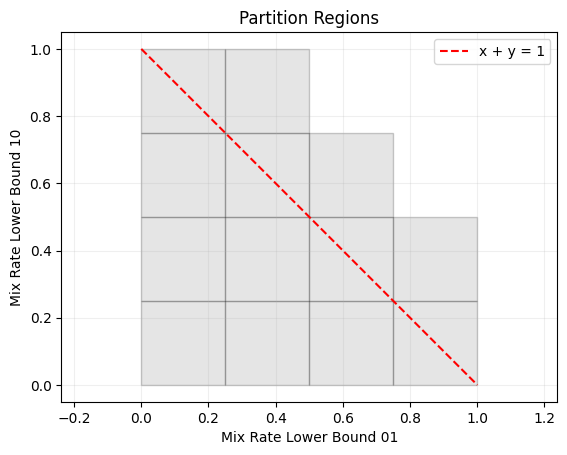

In [7]:
plot_partitions(PARTITIONS)

# Run Experiments

In [7]:
for (env_name, mix_rate), conf in configs.items(): 
    study_name = get_study_name(env_name, mix_rate)
    study_dir = Path(hparam_dir, study_name)
    study_dir.mkdir(exist_ok=True, parents=True)
    
    # create study (must create it here to nodes don't conflict)
    study = optuna.create_study(study_name=study_name, storage=get_storage_path(study_dir), direction="minimize", load_if_exists=True)  
    
    # run study
    n_trials_per_node = N_TRIALS // NODES_PER_STUDY
    cmds = [
        {
            **get_study_args_dict(conf, SCRIPT_NAME, update_hparam_map(hparam_map, i), n_trials_per_node, 0, study_name, study_dir), 
            "sampler_seed": i, 
            "sampler_type": SAMPLER
        } for i in range(NODES_PER_STUDY)
    ]
    executor = get_executor(study_dir, mem_gb=dataset_to_mem_gb[env_name], slurm_array_parallelism=NODES_PER_STUDY)

    jobs = run_experiments(executor, cmds, STUDY_SCRIPT_NAME)

[I 2025-02-04 07:49:50,495] A new study created in RDB with name: toy_grid_0.1
[I 2025-02-04 07:49:50,762] A new study created in RDB with name: toy_grid_0.25
[I 2025-02-04 07:49:50,916] A new study created in RDB with name: toy_grid_0.5
[I 2025-02-04 07:49:51,156] A new study created in RDB with name: toy_grid_0.75
[I 2025-02-04 07:49:51,314] A new study created in RDB with name: toy_grid_1.0
[I 2025-02-04 07:49:51,477] A new study created in RDB with name: fmnist_mnist_0.1
[I 2025-02-04 07:49:51,635] A new study created in RDB with name: fmnist_mnist_0.25
[I 2025-02-04 07:49:51,789] A new study created in RDB with name: fmnist_mnist_0.5
[I 2025-02-04 07:49:51,937] A new study created in RDB with name: fmnist_mnist_0.75
[I 2025-02-04 07:49:52,089] A new study created in RDB with name: fmnist_mnist_1.0
[I 2025-02-04 07:49:52,232] A new study created in RDB with name: cifar_mnist_0.1
[I 2025-02-04 07:49:52,383] A new study created in RDB with name: cifar_mnist_0.25
[I 2025-02-04 07:49:5

# Process Results

In [25]:
DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

In [7]:
# load study 
hparam_dir = "output/cc_mix_rate_lower_bound_sweep/2025-02-04_07-49-39"

In [8]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
import json
import yaml
import pandas as pd
import numpy as np
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(hparam_dir).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        if exp_dir.name == "0":
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])
        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)

In [12]:
df.to_csv(Path(hparam_dir) / "results.csv", index=False)

In [9]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_10'], 
        c=data['source_acc'],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}')
    
    plt.tight_layout()
    plt.show()

In [10]:
# TODO: get ERM mean and std 
mean_source_accs = {
    'celebA-0': 0.996,
    'cifar_mnist': 1.0,
    'fmnist_mnist': 1.0,
    'toy_grid': 0.999,
    'waterbirds': 0.984
}

std_source_accs = {
    'celebA-0': 0.0,
    'cifar_mnist': 0.0,
    'fmnist_mnist': 0.0,
    'toy_grid': 0.002,
    'waterbirds': 0.004
}

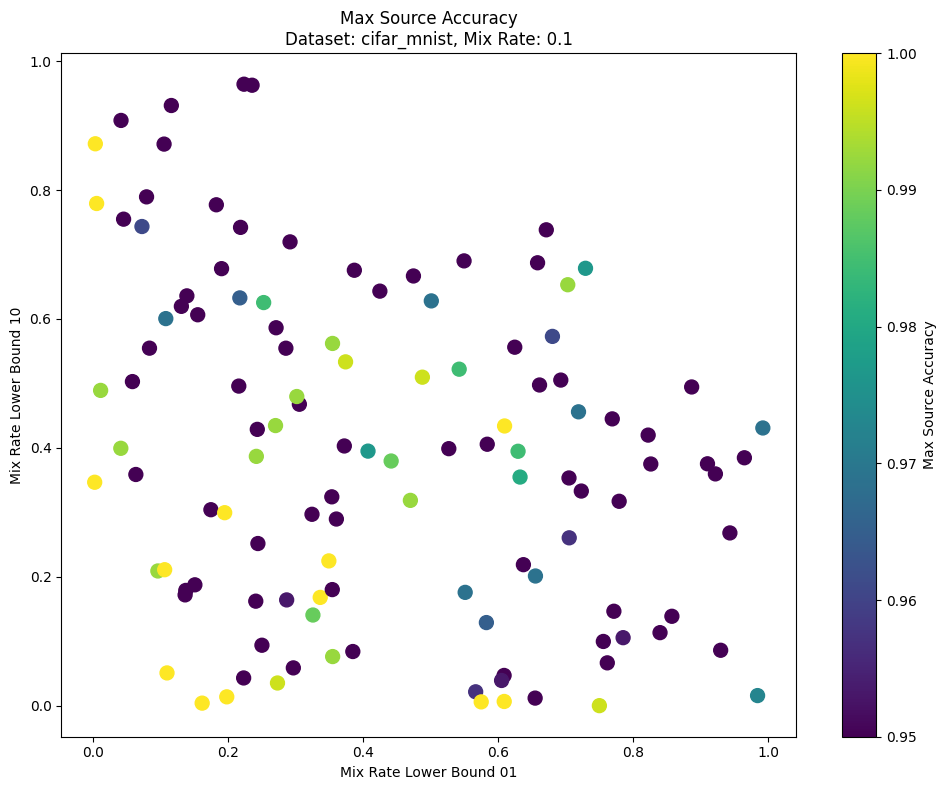

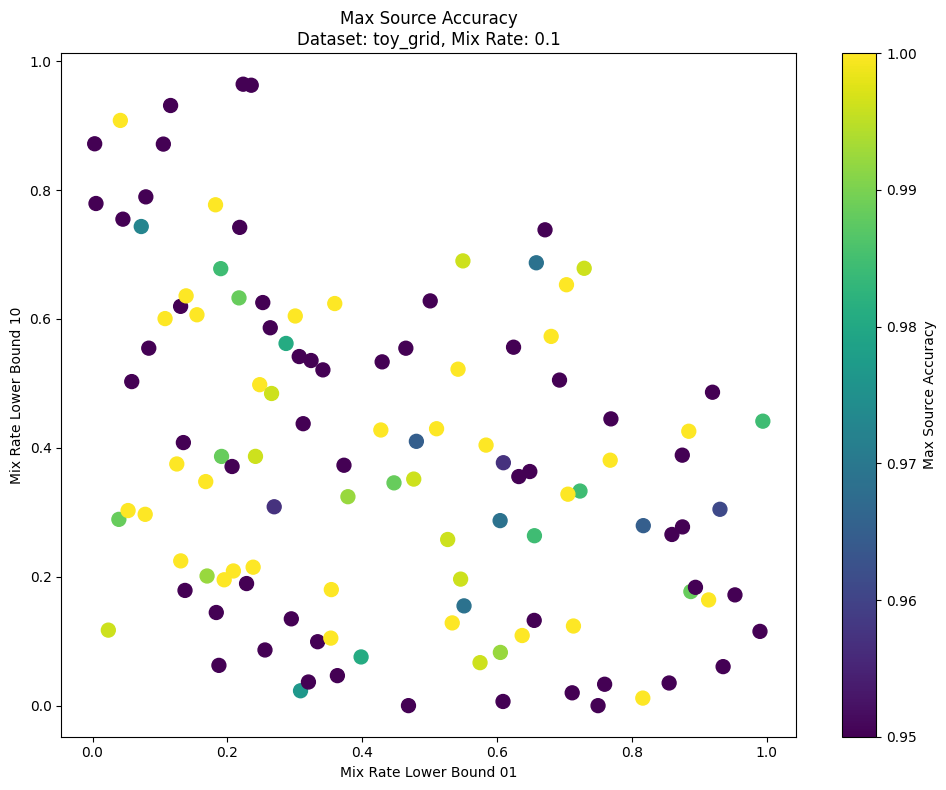

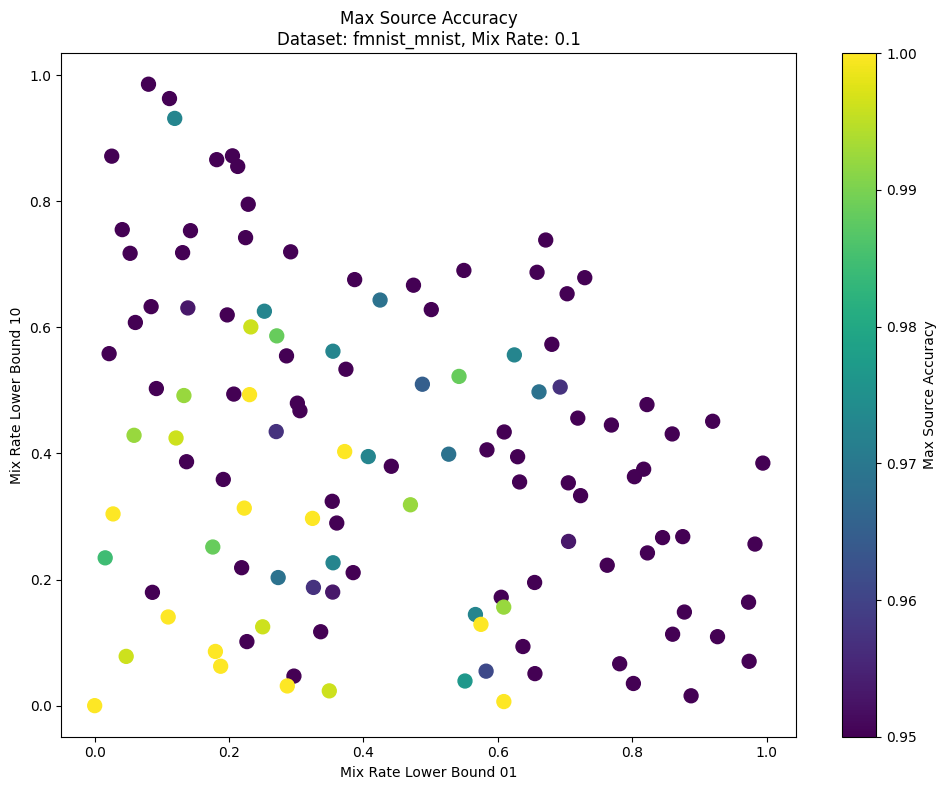

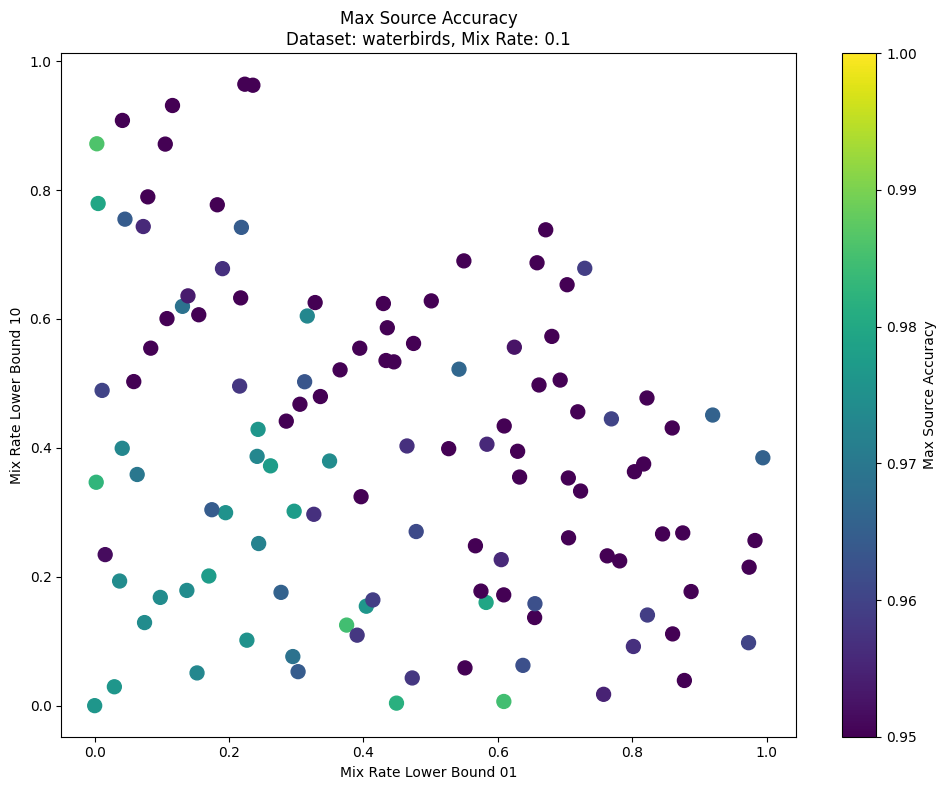

In [17]:
# Example usage:
mix_rate = 0.1
vmin = 0.95
vmax = 1.0
plot_mix_rate_accuracy(df, dataset='cifar_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='toy_grid', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='fmnist_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=0.95, vmax=1.0)

## Correlation Between Source Acc and Target Acc

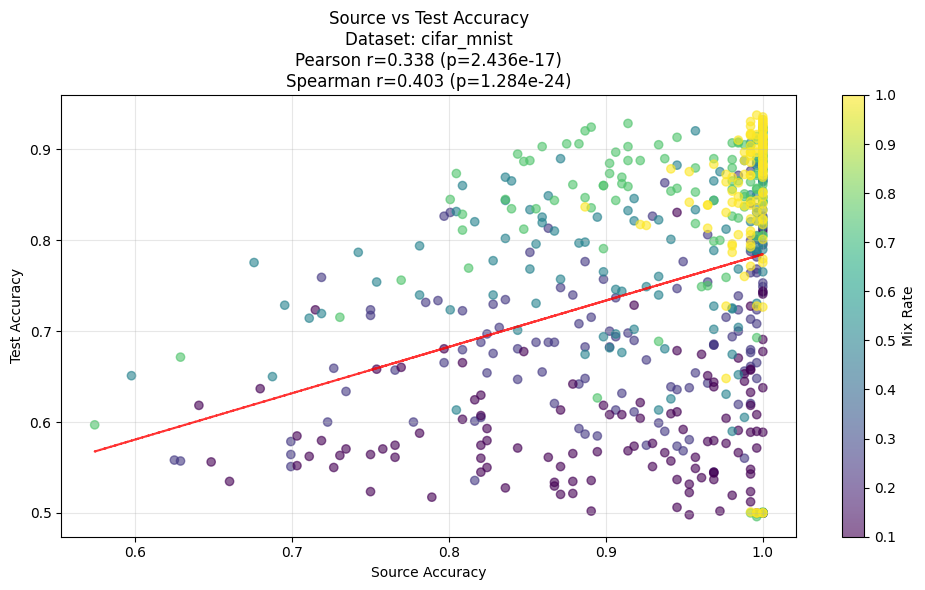

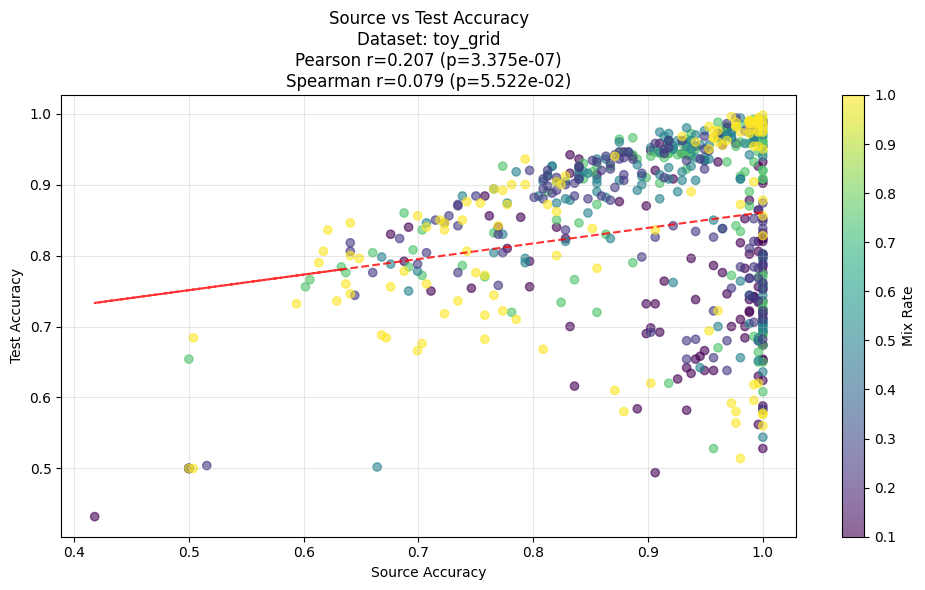

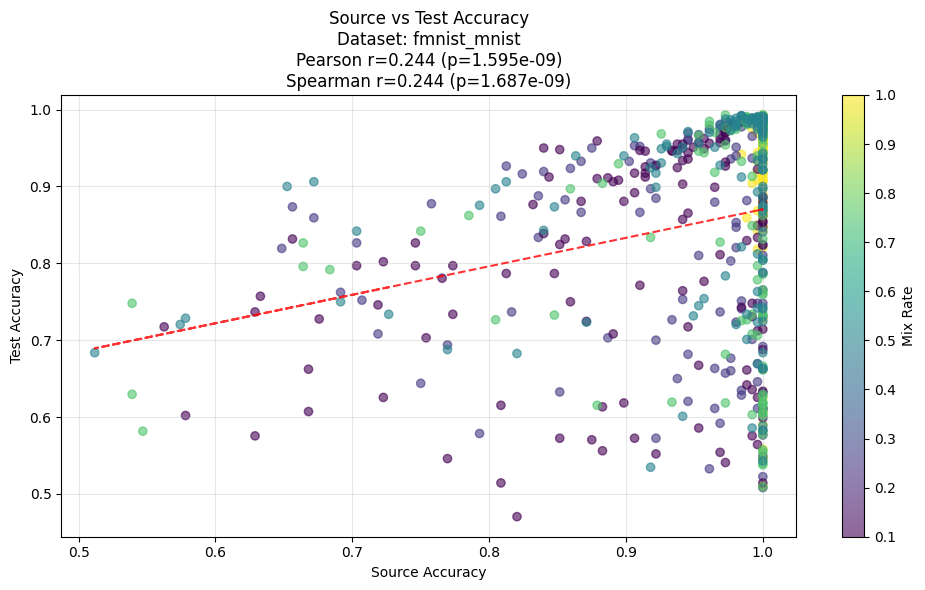

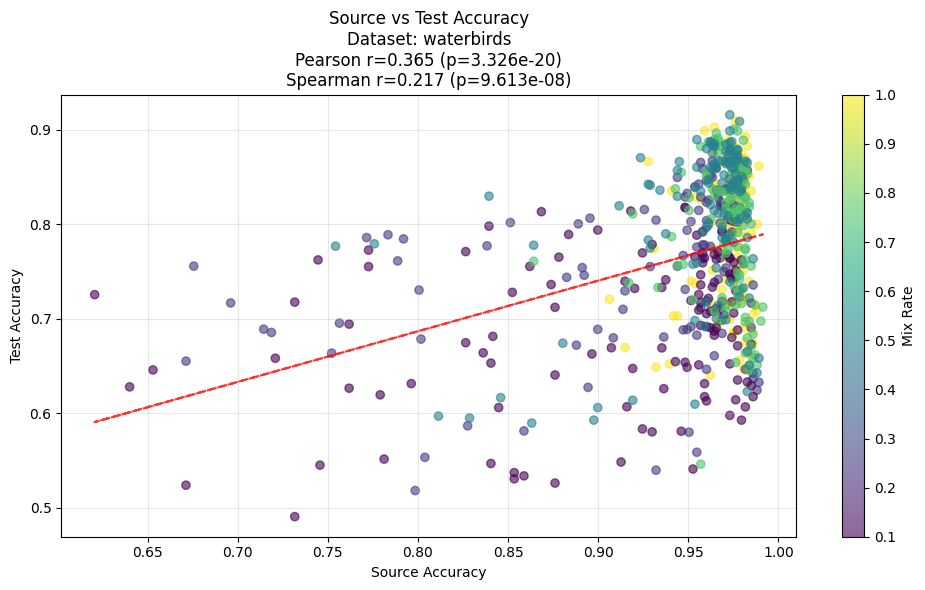

{'pearson_r': 0.3651421462796486,
 'pearson_p': 3.3263417057826496e-20,
 'spearman_r': 0.21652439308638502,
 'spearman_p': 9.612864592277381e-08}

In [ ]:
def analyze_source_target_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between source and target accuracy for a given dataset.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['source_acc'], data['test_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['source_acc'], data['test_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot with color based on mix rate
    scatter = plt.scatter(
        data['source_acc'],
        data['test_acc'],
        c=data['mix_rate'] if mix_rate is None else data['mix_rate_lb_01'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate' if mix_rate is None else 'Mix Rate LB 01')
    
    # Add correlation line
    z = np.polyfit(data['source_acc'], data['test_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['source_acc'], p(data['source_acc']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('Source Accuracy')
    plt.ylabel('Test Accuracy')
    title = f'Source vs Test Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

In [ ]:

# Example usage:
# For all mix rates:
analyze_source_target_correlation(df, dataset='cifar_mnist')
analyze_source_target_correlation(df, dataset='toy_grid')
analyze_source_target_correlation(df, dataset='fmnist_mnist')
analyze_source_target_correlation(df, dataset='waterbirds')

## Correlation Between Min(Mix Rate LB - Mix RATE, 0) and Source Acc

In [28]:
def analyze_mix_rate_lb_correlation_unified(
    df, 
    datasets, 
    acc_metric: str =  "source_acc", 
    ylabel: str = "Source Accuracy",
    figsize=(15, 10)
):
    """
    Create unified subplot figure analyzing correlation between excess mix rate 
    lower bound and source accuracy for multiple datasets.
    
    Args:
        df: DataFrame containing the results
        datasets: list of dataset names to analyze
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Set up subplot grid
    n_datasets = len(datasets)
    n_rows = (n_datasets + 1) // 2  # Round up division
    n_cols = min(2, n_datasets)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Store correlations for each dataset and mix rate
    correlations = {}
    
    # Color map for mix rates
    unique_mix_rates = sorted(df['mix_rate'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_mix_rates)))
    mix_rate_to_color = dict(zip(unique_mix_rates, colors))
    
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        correlations[dataset] = {}
        
        # Filter data for dataset
        data = df[df['dataset'] == dataset].copy()
        
        # Calculate excess mix rate lower bound
        data['excess_mix_rate_lb'] = np.maximum(
            data['mix_rate_lb_01'] + data['mix_rate_lb_10'] - data['mix_rate'],
            0
        )
        
        # Plot scatter and compute correlations for each mix rate
        for mix_rate in unique_mix_rates:
            mix_rate_data = data[data['mix_rate'] == mix_rate]
            
            # Compute correlation for this mix rate
            if len(mix_rate_data) > 1:  # Need at least 2 points for correlation
                pearson_r, p_value = stats.pearsonr(
                    mix_rate_data['excess_mix_rate_lb'], 
                    mix_rate_data[acc_metric]
                )
                correlations[dataset][mix_rate] = {
                    'pearson_r': pearson_r,
                    'p_value': p_value
                }
                # Modified label format to include correlation coefficient
                label = f'{mix_rate:.2f}|{pearson_r:.3f}'
            else:
                label = f'{mix_rate:.2f}|NA'
            
            # Plot scatter with updated label
            ax.scatter(
                mix_rate_data['excess_mix_rate_lb'],
                mix_rate_data[acc_metric],
                c=[mix_rate_to_color[mix_rate]],
                alpha=0.6,
                label=label
            )
            
            # Add correlation line for this mix rate
            if len(mix_rate_data) > 1:
                z = np.polyfit(mix_rate_data['excess_mix_rate_lb'], mix_rate_data[acc_metric], 1)
                p = np.poly1d(z)
                x_range = np.array([mix_rate_data['excess_mix_rate_lb'].min(), 
                                mix_rate_data['excess_mix_rate_lb'].max()])
                ax.plot(x_range, p(x_range), "--", color=mix_rate_to_color[mix_rate], alpha=0.8)
        
            ax.set_xlabel('Excess Mix Rate LB')
            ax.set_ylabel(ylabel)
            ax.set_title(f'{DATASET_TITLES[dataset]}')
            ax.grid(True, alpha=0.3)
            
            # Add legend to each subplot
            ax.legend(title='mix_rate|r')
    
    # Remove any unused subplots
    for idx in range(len(datasets), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return correlations

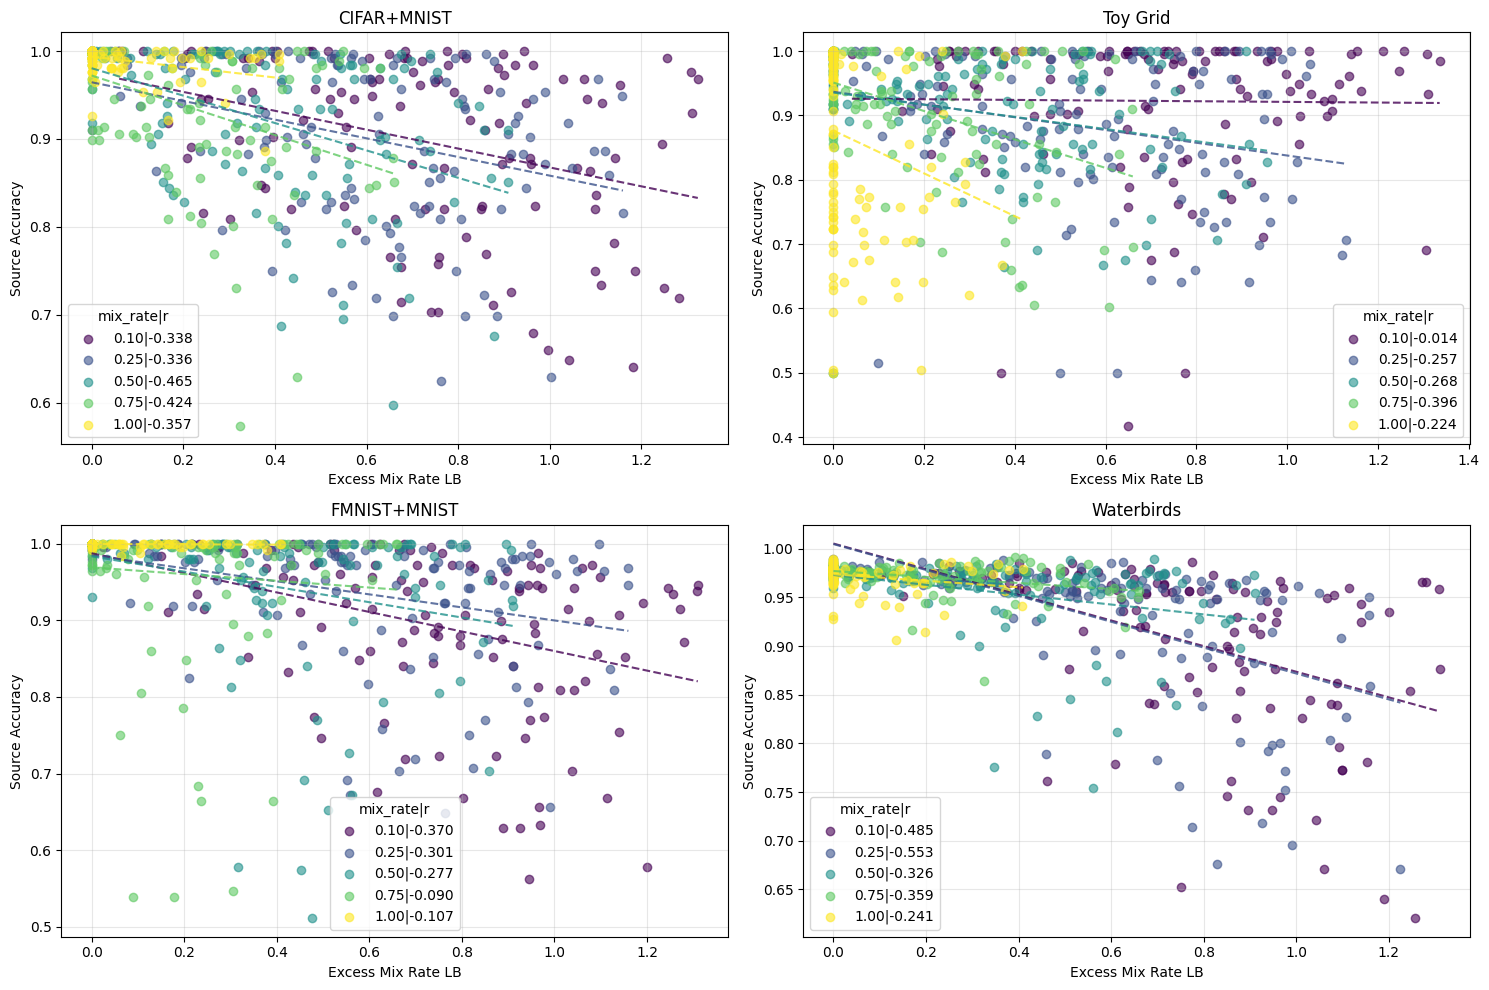

In [29]:
datasets = ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']
correlations = analyze_mix_rate_lb_correlation_unified(df, datasets)

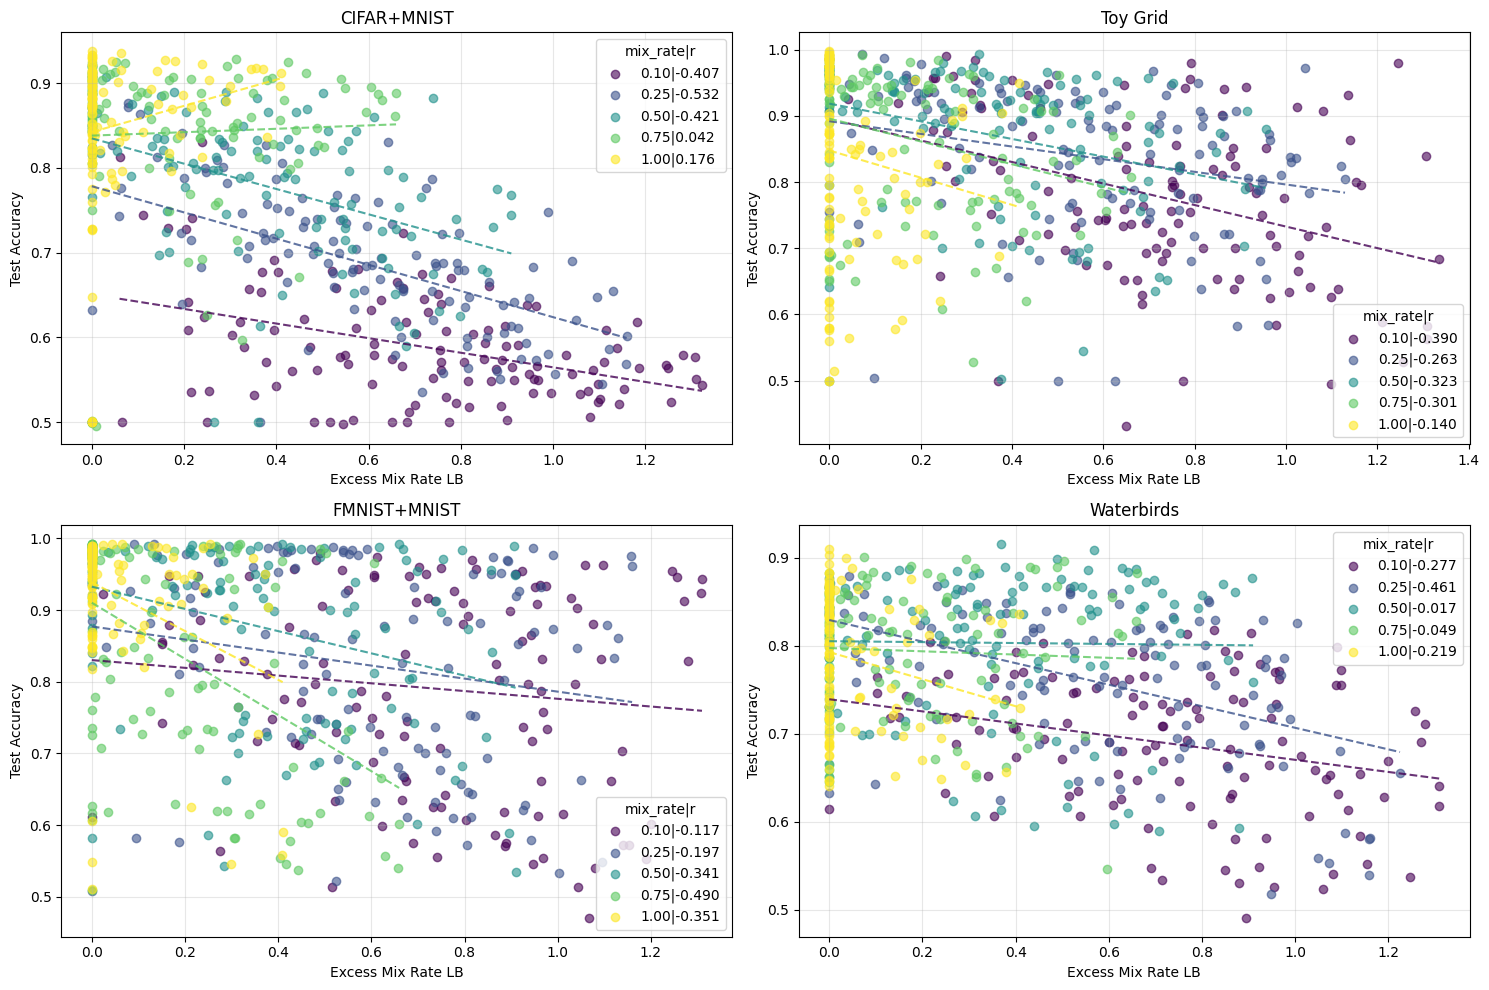

In [30]:
datasets = ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']
correlations = analyze_mix_rate_lb_correlation_unified(df, datasets, 
                                                       acc_metric="test_acc", ylabel="Test Accuracy")